# Methodology
* In this notebook we'll use pre computed **bounding box** from **YOLOv5** model to create **Cropped Dataset**.
* To create **Bounding Boxes**, [Happywhale: BoundingBox [YOLOv5] 🐋🐬](https://www.kaggle.com/awsaf49/happywhale-boundingbox-yolov5) notebook was used.
* You can choose **Image Size** for the image.
* You can also tune the **Conf** Parameter to get the best suited bbox for this competiiton.

# Notebooks 
Here are some of my notebooks for this competition, **please upvote if you find them useful**
* [Happywhale: BoundingBox [YOLOv5] 🐋🐬](https://www.kaggle.com/awsaf49/happywhale-boundingbox-yolov5)
* [Happywhale: Cropped Dataset [YOLOv5] ✂️](https://www.kaggle.com/awsaf49/happywhale-cropped-dataset-yolov5)
* [Happywhale: Data Distribution 🐋🐬](https://www.kaggle.com/awsaf49/happywhale-data-distribution)

# Install Libraries

In [21]:
!pip install -q bbox-utility 
#  check https://github.com/awsaf49/bbox for source code

# Import Libraries

In [76]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from bbox.utils import yolo2voc, draw_bboxes

import cv2
import matplotlib.pyplot as plt

# Config

In [77]:
BASE_PATH = 'C:/Users/Ishaan/Downloads/DATA/happy-whale-and-dolphin'

ROOT_DIR = 'C:/Users/Ishaan/Downloads/DATA/happy-whale-and-dolphin'
IMAGE_DIR = 'C:/Users/Ishaan/Downloads/DATA/data' # directory to save images
IMAGE_DIR_testing = 'C:/Users/Ishaan/Downloads/DATA/test_images' 
LABEL_DIR = 'C:/Users/Ishaan/Downloads/DATA/labels'  # directory to save labels
IMG_SIZE = (256, 256) # new image resolution
CONF = 0.01 # confidence threshold for bbox

In [78]:
# Train Data
df = pd.read_csv(f"{ROOT_DIR}/train2.csv")
print(df)
df["image_id"] = df["image"]
df["old_image_path"] = f"{ROOT_DIR}/train_images/" + df.image_id.astype(str)
df["image_path"] = f"{IMAGE_DIR}/" + df.image_id
df["label_path"] = f"{LABEL_DIR}/" + df.image_id.str.replace("jpg", "txt")
df.head(2)

                             bbox    class         conf  height  \
0           [[34, 118, 804, 633]]    whale   [0.230225]     671   
1          [[0, 602, 3504, 1503]]    whale   [0.530273]    2336   
2          [[0, 479, 3436, 1305]]    whale   [0.162964]    2399   
3           [[0, 98, 3394, 1647]]  dolphin   [0.516602]    2336   
4           [[90, 54, 3599, 755]]    whale   [0.489258]    2699   
...                           ...      ...          ...     ...   
51028  [[1301, 1234, 2240, 1376]]    whale  [0.0158997]    2400   
51029     [[2070, 69, 2368, 166]]    whale  [0.0121002]    2250   
51030         [[0, 0, 2282, 309]]    whale    [0.21936]     315   
51031    [[55, 1024, 3296, 1488]]    whale   [0.197754]    2391   
51032   [[1447, 868, 3075, 1411]]  dolphin   [0.390381]    2304   

                    image            image_id  \
0      00021adfb725ed.jpg  00021adfb725ed.jpg   
1      000562241d384d.jpg  000562241d384d.jpg   
2      0007c33415ce37.jpg  0007c33415ce37.jpg   

bbox  class        conf  height               image  \
0   [[34, 118, 804, 633]]  whale  [0.230225]     671  00021adfb725ed.jpg   
1  [[0, 602, 3504, 1503]]  whale  [0.530273]    2336  000562241d384d.jpg   

             image_id                                         image_path  \
0  00021adfb725ed.jpg  C:/Users/Ishaan/Downloads/DATA/data/00021adfb7...   
1  000562241d384d.jpg  C:/Users/Ishaan/Downloads/DATA/data/000562241d...   

  individual_id                                         label_path  \
0  cadddb1636b9  C:/Users/Ishaan/Downloads/DATA/labels/00021adf...   
1  1a71fbb72250  C:/Users/Ishaan/Downloads/DATA/labels/00056224...   

              species  split  width  \
0  melon_headed_whale  Train    804   
1      humpback_whale  Train   3504   

                                      old_image_path  
0  C:/Users/Ishaan/Downloads/DATA/happy-whale-and...  
1  C:/Users/Ishaan/Downloads/DATA/happy-whale-and...

# Meta Data

In [79]:
df = pd.read_csv(BASE_PATH+'/train2.csv')
print (df)
df["image_id"] = df["image"]
df["old_image_path"] = f"{ROOT_DIR}/train_images/" + df.image_id.astype(str)
df["image_path"] = f"{IMAGE_DIR}/" + df.image_id
df["label_path"] = f"{LABEL_DIR}/" + df.image_id.str.replace("jpg", "txt")
df['label_path'] = df['label_path'].map(lambda x: x.replace('/kaggle/working',BASE_PATH))

test_df = pd.read_csv(BASE_PATH+'/test2.csv')
test_df["image_id"] = test_df["image"]
test_df["old_image_path"] = f"{ROOT_DIR}/train_images/" + test_df.image_id.astype(str)
test_df["image_path"] = f"{IMAGE_DIR_testing}/" + test_df.image_id
test_df["label_path"] = f"{LABEL_DIR}/" + test_df.image_id.str.replace("jpg", "txt")
test_df['label_path'] = test_df['label_path'].map(lambda x: x.replace('/kaggle/working',BASE_PATH))
test_df['label_path'] = test_df['label_path'].map(lambda x: x.replace('/kaggle/working',BASE_PATH))
test_df.head(2)

                             bbox    class         conf  height  \
0           [[34, 118, 804, 633]]    whale   [0.230225]     671   
1          [[0, 602, 3504, 1503]]    whale   [0.530273]    2336   
2          [[0, 479, 3436, 1305]]    whale   [0.162964]    2399   
3           [[0, 98, 3394, 1647]]  dolphin   [0.516602]    2336   
4           [[90, 54, 3599, 755]]    whale   [0.489258]    2699   
...                           ...      ...          ...     ...   
51028  [[1301, 1234, 2240, 1376]]    whale  [0.0158997]    2400   
51029     [[2070, 69, 2368, 166]]    whale  [0.0121002]    2250   
51030         [[0, 0, 2282, 309]]    whale    [0.21936]     315   
51031    [[55, 1024, 3296, 1488]]    whale   [0.197754]    2391   
51032   [[1447, 868, 3075, 1411]]  dolphin   [0.390381]    2304   

                    image            image_id  \
0      00021adfb725ed.jpg  00021adfb725ed.jpg   
1      000562241d384d.jpg  000562241d384d.jpg   
2      0007c33415ce37.jpg  0007c33415ce37.jpg   

image                                        predictions  \
0  000110707af0ba.jpg  37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...   
1  0006287ec424cb.jpg  37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...   

                                          image_path split  width  height  \
0  C:/Users/Ishaan/Downloads/DATA/test_images/000...  Test   3599    2399   
1  C:/Users/Ishaan/Downloads/DATA/test_images/000...  Test   3600    2400   

             image_id                                         label_path  \
0  000110707af0ba.jpg  C:/Users/Ishaan/Downloads/DATA/labels/00011070...   
1  0006287ec424cb.jpg  C:/Users/Ishaan/Downloads/DATA/labels/0006287e...   

         conf                       bbox  \
0  [0.218018]     [[0, 807, 3599, 1360]]   
1  [0.102295]  [[769, 1632, 2242, 1905]]   

                                      old_image_path  
0  C:/Users/Ishaan/Downloads/DATA/happy-whale-and...  
1  C:/Users/Ishaan/Downloads/DATA/happy-whale-and...

# Get Annotation

In [80]:
df = df.fillna('[]')
test_df = test_df.fillna('[]')

In [81]:
df['bbox'] = df['bbox'].map(eval)
test_df['bbox'] = test_df['bbox'].map(eval)

df['conf'] = df['conf'].map(eval)
test_df['conf'] = test_df['conf'].map(eval)

# Crop Utility

In [87]:
def load_image(path):

    return cv2.imread(path)[...,::-1]

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

def crop_image(row):
    image_path = row['image_path']
    if 'train' in image_path:
        save_dir = 'C:/Users/Ishaan/Downloads/DATA/train'
    else:
        save_dir = 'C:/Users/Ishaan/Downloads/DATA/test'
    img = load_image(image_path)
    if len(row['bbox']): # if there is no bbox
        bbox = row['bbox'][0]
        conf = row['conf'][0]
        if conf>=CONF: # don't crop for poor confident bboxes
            
            xmin, ymin, xmax, ymax = bbox
            img = img[ymin:ymax, xmin:xmax] # crop image
    else:
            
    img = cv2.resize(img[...,::-1], dsize=IMG_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(f'{save_dir}/{row.image_id}', img) # save image in the new directory
    
    return

# Visualize

## Train

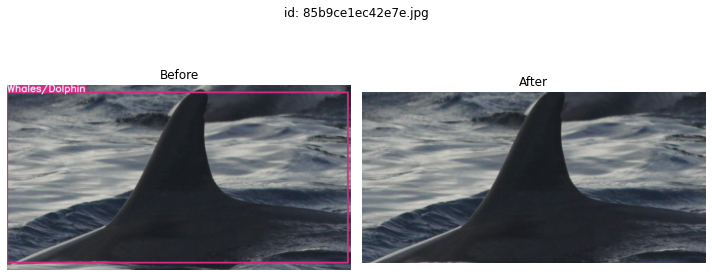

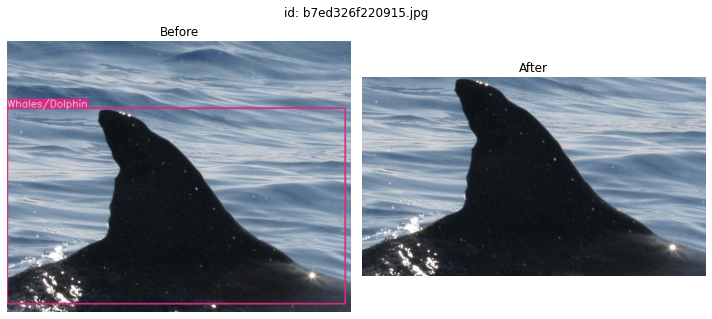

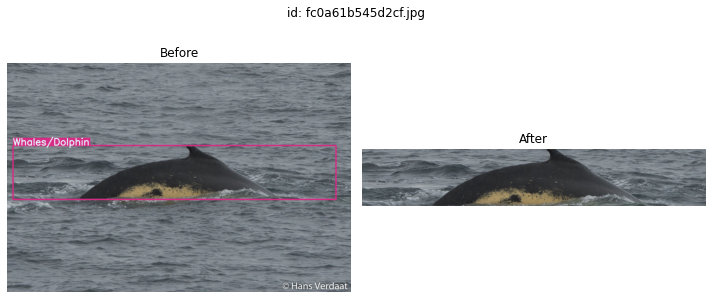

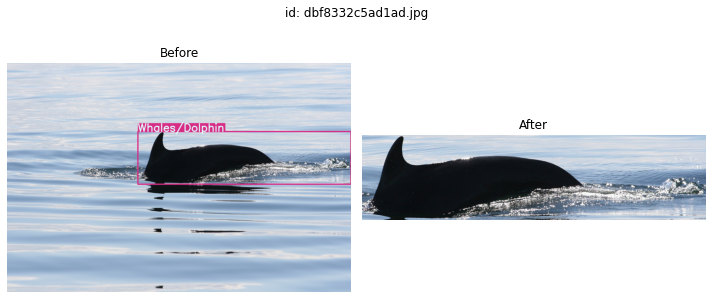

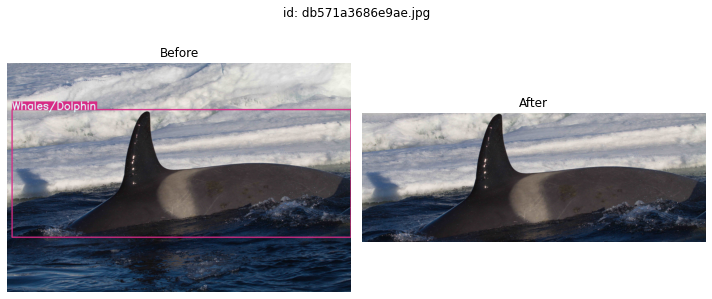

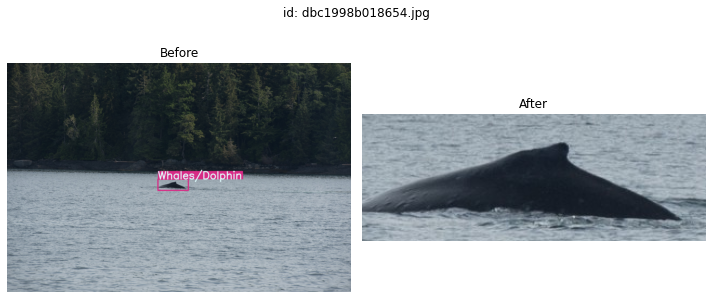

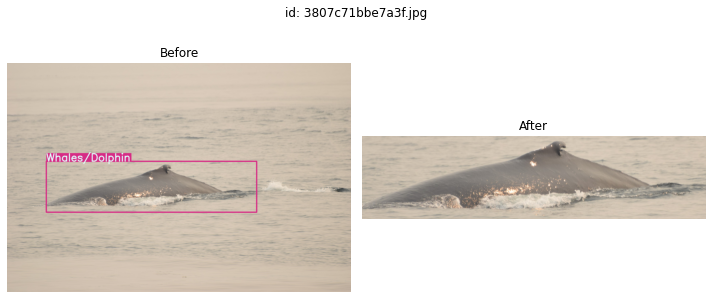

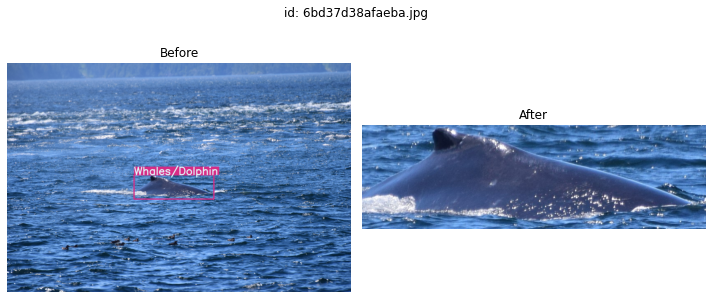

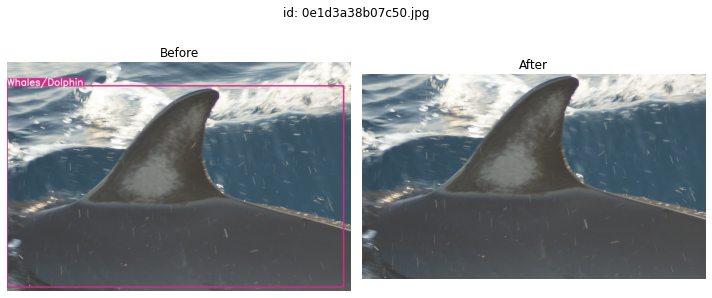

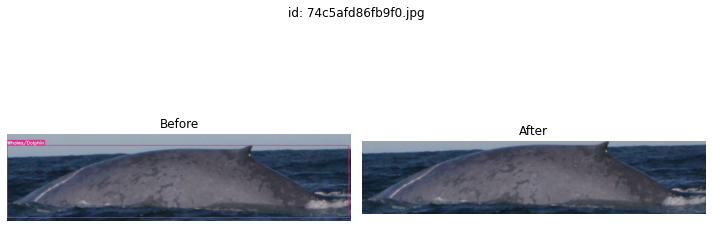

In [88]:
for i in range(10):
    row = df.sample(frac=1.0).iloc[i]
    img = load_image(row.image_path)
    bbox = row['bbox'][0]
    xmin, ymin, xmax, ymax = bbox

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
#     plt.imshow(img)
    dim = np.sqrt(np.prod(img.shape[:2]))
    line_thickness = int(2/512*dim)
    plt.imshow(
            draw_bboxes(
                img=img,
                bboxes=np.array(row['bbox']),
                classes=['Whales/Dolphin'],
                class_ids=[0],
                class_name=True,
                colors=colors,
                bbox_format="voc",
                line_thickness=line_thickness,
            ))
    plt.title('Before')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img[ymin:ymax, xmin:xmax])
    plt.title('After')
    plt.axis('off')
    
    plt.suptitle(f'id: {row.image_id}', y=0.94)
    plt.tight_layout()
    plt.show()

## Test

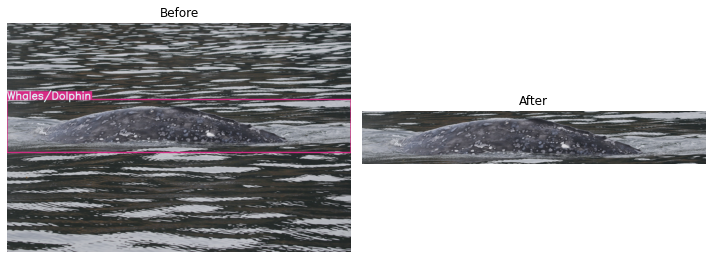

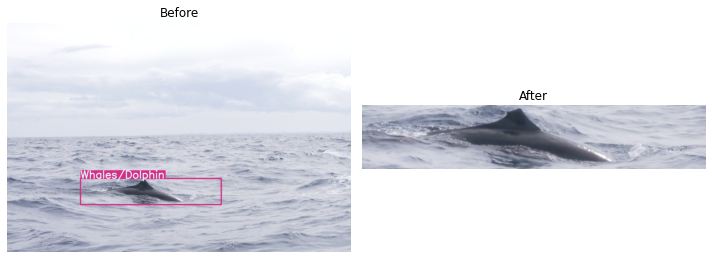

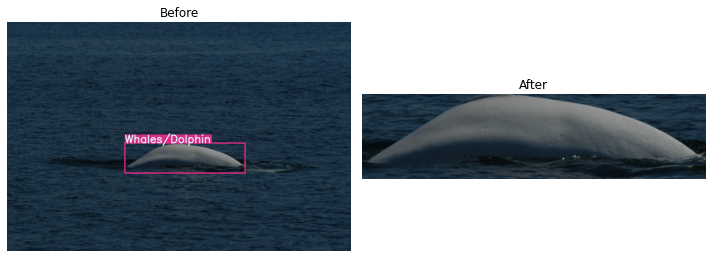

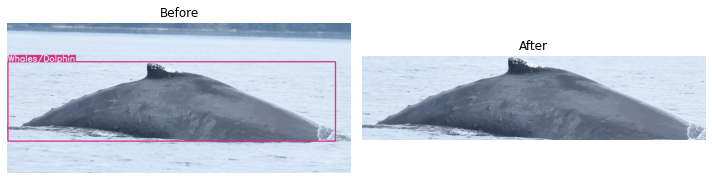

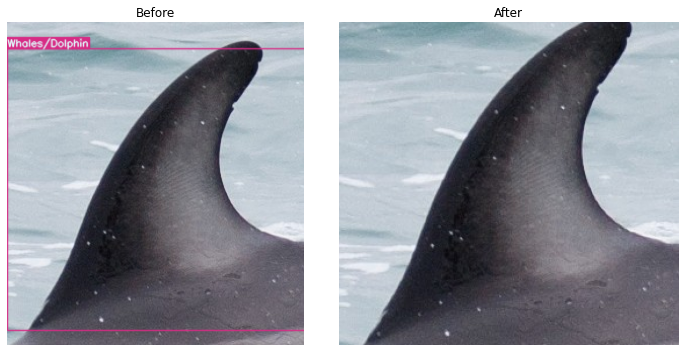

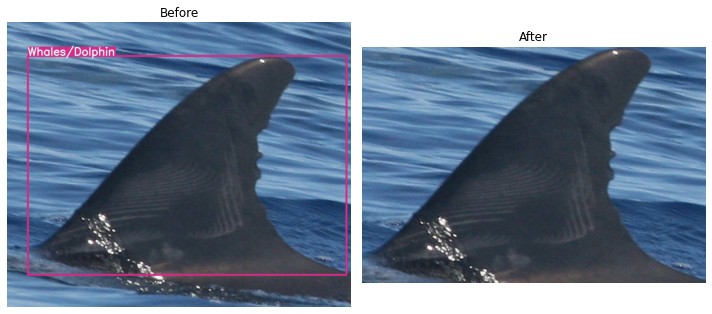

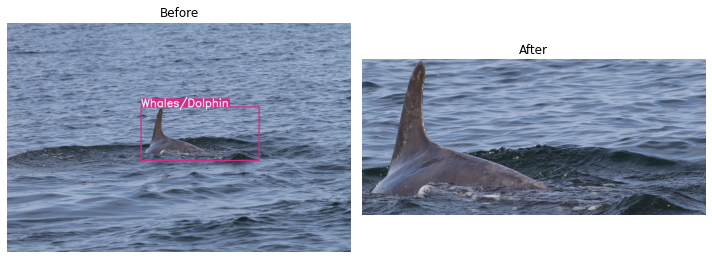

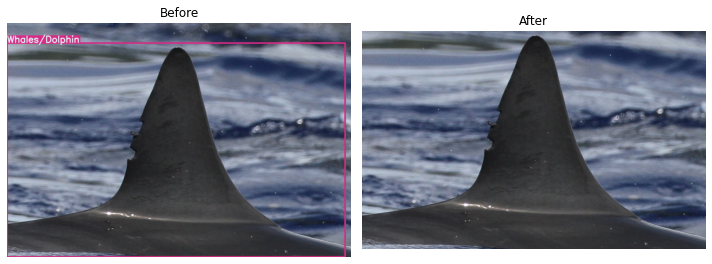

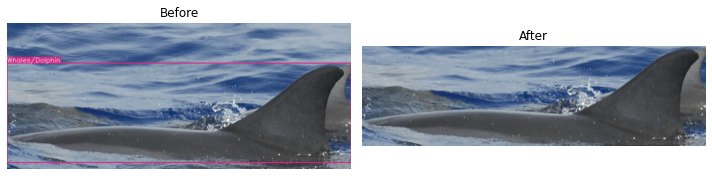

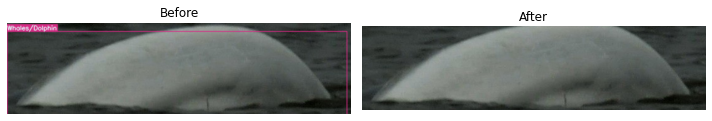

In [89]:
for i in range(10):
    row = test_df.iloc[i]
    img = load_image(row.image_path)
    bbox = row['bbox'][0]
    xmin, ymin, xmax, ymax = bbox

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
#     plt.imshow(img)
    dim = np.sqrt(np.prod(img.shape[:2]))
    line_thickness = int(2/512*dim)
    plt.imshow(
            draw_bboxes(
                img=img,
                bboxes=np.array(row['bbox']),
                classes=['Whales/Dolphin'],
                class_ids=[0],
                class_name=True,
                colors=colors,
                bbox_format="voc",
                line_thickness=line_thickness,
            ))
    plt.title('Before')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img[ymin:ymax, xmin:xmax])
    plt.title('After')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Crop

In [91]:
# Train
_ = Parallel(n_jobs=-1, backend='threading')(delayed(crop_image)(row)\
                                         for _, row in tqdm(df.iterrows(), total=len(df), desc='train '))

# Test
_ = Parallel(n_jobs=-1, backend='threading')(delayed(crop_image)(row)\
                                         for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc='test '))

train :   0%|          | 0/51033 [00:00<?, ?it/s]

none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none


test :   0%|          | 0/27956 [00:00<?, ?it/s]

# Save Meta Data

In [93]:
df.to_csv('train_final.csv',index=False)
test_df.to_csv('test_final.csv',index=False)